In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
import theano.tensor as T

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}) ,
    (Flatten, [], {'which_sources': 'features'}) )

cifar_train = CIFAR10(("train",), subset=slice(None,40000))
cifar_train_stream = DataStream.default_stream(
    cifar_train, iteration_scheme=ShuffledScheme(cifar_train.num_examples, 100))
                                               
cifar_validation = CIFAR10(("train",), subset=slice(40000, None))
cifar_validation_stream = DataStream.default_stream(
    cifar_validation, iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))

cifar_test = CIFAR10(("test",))
cifar_test_stream = DataStream.default_stream(
    cifar_test, iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))

In [4]:
from modules.Network import Network
from modules.layers.SoftMaxLayer import SoftMaxLayer
from modules.layers.AffineLayer import AffineLayer
from modules.layers.ConvolutionalPoolLayer import ConvolutionalPoolLayer
from modules.initializers.Normal import Normal

/home/i258361/Dokumenty/nn_project/CIFAR10-classificator/libs/Theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [5]:
ReLU = lambda x: T.maximum(0.0, x)

net = Network([ConvolutionalPoolLayer(image_shape=(3,32,32), filter_shape=(32,3,5,5), pool_shape=(2,2), conv_mode='same'),
               ConvolutionalPoolLayer(image_shape=(32,16,16), filter_shape=(64,32,5,5), pool_shape=(2,2), conv_mode='same'),
               ConvolutionalPoolLayer(image_shape=(64,8,8), filter_shape=(128,64,5,5), pool_shape=(2,2), conv_mode='same'),
               AffineLayer(128*4*4, 512, activation=ReLU),
               SoftMaxLayer(512, 10, weights_initializer=Normal(std=0.08)) ])

train_cost, valid_errors, train_errors = net.train(cifar_train_stream, cifar_validation_stream, 8e-3, 0.95, 1e-3)

At batch #100, batch cost: 3.776503
At batch #200, batch cost: 3.658404
At batch #300, batch cost: 3.241800
At batch #400, batch cost: 2.866297
After epoch 1: validation error: 43.980000%
Currently going to do 3 epochs
At batch #500, batch cost: 2.679255
At batch #600, batch cost: 2.719731
At batch #700, batch cost: 2.423378
At batch #800, batch cost: 2.301649
After epoch 2: validation error: 35.580000%
Currently going to do 4 epochs
At batch #900, batch cost: 2.330848
At batch #1000, batch cost: 2.097350
At batch #1100, batch cost: 2.120095
At batch #1200, batch cost: 1.839159
After epoch 3: validation error: 30.840000%
Currently going to do 5 epochs
At batch #1300, batch cost: 1.775902
At batch #1400, batch cost: 1.520970
At batch #1500, batch cost: 1.688003
At batch #1600, batch cost: 1.677832
After epoch 4: validation error: 29.120000%
Currently going to do 7 epochs
At batch #1700, batch cost: 1.592917
At batch #1800, batch cost: 1.493343
At batch #1900, batch cost: 1.460852
At bat

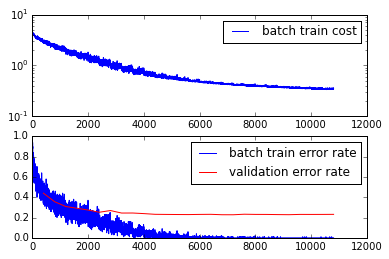

In [6]:
subplot(2,1,1)
semilogy(train_cost[:,0], train_cost[:,1], label='batch train cost')
legend()

subplot(2,1,2)
plot(train_errors[:,0], train_errors[:,1], label='batch train error rate')
plot(valid_errors[:,0], valid_errors[:,1], label='validation error rate', color='r')
legend()

In [7]:
net.compute_error_rate(cifar_test_stream, save=True)

0.2395